# CNV-Espresso training process

In [4]:
from __future__ import print_function
import os
import re
import copy
import random
import datetime
import timeit

import PIL
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn

import tensorflow as tf
from tensorflow import keras
import keras.preprocessing
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend

import function_dl as func_dl
import function as func

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variables

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [71]:
project_dir = '/home/rt2776/cnv_espresso/project4_method_development'
output_model_dir = project_dir + '/train/'
batch_size = 32
epochs     = 20

In [ ]:
img_width, img_height = 224, 224
seed = 2021

## Importing data from scratch

### Import file path

In [7]:
## For rare CNVs

true_del_file  = project_dir + '/train/true_del.list'
true_dup_file  = project_dir + '/train/true_dup.list'
false_del_file = project_dir + '/train/false_del.list'
false_dup_file = project_dir + '/train/false_dup.list'


true_del_df  = pd.read_csv(true_del_file,  header=0,sep='\t')
false_del_df = pd.read_csv(false_del_file, header=0,sep='\t')

true_dup_df  = pd.read_csv(true_dup_file,  header=0,sep='\t')
false_dup_df = pd.read_csv(false_dup_file, header=0,sep='\t')

true_del_images_path_list  = true_del_df['img_path']
false_del_images_path_list = false_del_df['img_path']

true_dup_images_path_list  = true_dup_df['img_path']
false_dup_images_path_list = false_dup_df['img_path']

In [13]:
print("The shape of each type:")
print("True  DEL:", true_del_images_path_list.shape)
print("True  DUP:", true_dup_images_path_list.shape)
print("False DEL:", false_del_images_path_list.shape)
print("False DUP:", false_dup_images_path_list.shape)

The shape of each type:
True  DEL: (5180,)
True  DUP: (10354,)
False DEL: (989,)
False DUP: (5485,)


### Loading images from list to numpy array

In [17]:
# # entire cnv
true_del_img_np = func_dl.loadImgs(true_del_images_path_list, img_width, img_height)
true_del_img_np.shape

false_del_img_np = func_dl.loadImgs(false_del_images_path_list, img_width, img_height)
false_del_img_np.shape

true_dup_img_np = func_dl.loadImgs(true_dup_images_path_list, img_width, img_height)
true_dup_img_np.shape

false_dup_img_np = func_dl.loadImgs(false_dup_images_path_list, img_width, img_height)
false_dup_img_np.shape

[2021.05.10-12:48:18] Processing 1 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_del/10009_SP0086927_10_106652381_106776692_15tgs_15wins_True_DEL.png...
[2021.05.10-12:48:37] Processing 101 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_del/10239_SP0088832_10_45663541_45721064_7tgs_7wins_True_DEL.png...
[2021.05.10-12:49:00] Processing 201 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_del/10527_SP0091718_5_141182559_141194955_8tgs_15wins_True_DEL.png...
[2021.05.10-12:49:21] Processing 301 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_del/1083_SP0012361_2_110123790_110204968_21tgs_21wins_True_DEL.png...
[2021.05.10-12:49:40] Processing 401 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_del/11067_SP0097707_7_150856470_150861209_4tgs_6wins_True_DEL.png...
[2021.05.10-12:50:01] Processing 501 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classe

[2021.05.10-13:03:08] Processing 4601 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_del/8357_SP0073275_2_208170944_208186986_7tgs_7wins_True_DEL.png...
[2021.05.10-13:03:28] Processing 4701 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_del/8618_SP0075683_12_20875234_20883602_5tgs_5wins_True_DEL.png...
[2021.05.10-13:03:46] Processing 4801 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_del/8859_SP0077617_19_39199169_39200756_3tgs_3wins_True_DEL.png...
[2021.05.10-13:04:07] Processing 4901 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_del/9133_SP0079849_19_544071_549791_5tgs_5wins_True_DEL.png...
[2021.05.10-13:04:27] Processing 5001 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_del/9456_SP0082568_19_4332021_4338944_4tgs_4wins_True_DEL.png...
[2021.05.10-13:04:48] Processing 5101 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_del/

[2021.05.10-13:18:13] Processing 3001 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_dup/14030_SP0132720_8_52538442_52685469_26tgs_28wins_True_DUP.png...
[2021.05.10-13:18:32] Processing 3101 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_dup/14166_SP0134684_3_10375428_10388402_6tgs_6wins_True_DUP.png...
[2021.05.10-13:18:49] Processing 3201 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_dup/14273_SP0135874_3_112536474_112561528_10tgs_10wins_True_DUP.png...
[2021.05.10-13:19:07] Processing 3301 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_dup/14379_SP0136734_21_33903934_33915763_6tgs_6wins_True_DUP.png...
[2021.05.10-13:19:26] Processing 3401 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_dup/14478_SP0136814_12_62648488_62832279_9tgs_9wins_True_DUP.png...
[2021.05.10-13:19:45] Processing 3501 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3clas

[2021.05.10-13:26:51] Processing 7601 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_dup/6231_SP0053719_11_62839113_62882999_8tgs_8wins_True_DUP.png...
[2021.05.10-13:27:01] Processing 7701 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_dup/6376_SP0055038_1_114397647_114464388_20tgs_20wins_True_DUP.png...
[2021.05.10-13:27:11] Processing 7801 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_dup/6514_SP0056269_10_46129882_46384833_42tgs_43wins_True_DUP.png...
[2021.05.10-13:27:21] Processing 7901 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_dup/666_SP0008433_19_10252396_10259813_8tgs_8wins_True_DUP.png...
[2021.05.10-13:27:32] Processing 8001 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/true_dup/6810_SP0058787_7_193199_291488_13tgs_13wins_True_DUP.png...
[2021.05.10-13:27:42] Processing 8101 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/tru

[2021.05.10-13:34:30] Processing 1801 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/false_dup/2914_SP0069020_22_40779008_40799083_6tgs_6wins_False_DUP.png...
[2021.05.10-13:34:41] Processing 1901 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/false_dup/3024_SP0071800_22_36800889_36817005_4tgs_4wins_False_DUP.png...
[2021.05.10-13:34:51] Processing 2001 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/false_dup/3131_SP0073858_17_76932644_76948838_8tgs_8wins_False_DUP.png...
[2021.05.10-13:35:02] Processing 2101 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/false_dup/3236_SP0077417_19_54219489_54220023_3tgs_3wins_False_DUP.png...
[2021.05.10-13:35:13] Processing 2201 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3classes/false_dup/3347_SP0080797_22_23287158_23309483_7tgs_7wins_False_DUP.png...
[2021.05.10-13:35:23] Processing 2301 /home/rt2776/cnv_espresso/project0_train_model/images_rare_3cl

(5485, 224, 224, 3)

### Generate labels for entire CNVs

In [18]:
# Three classes
true_del_label = [0 for i in range(0,len(true_del_img_np))]
false_del_label = [1 for i in range(0,len(false_del_img_np))]

true_dup_label = [2 for i in range(0,len(true_dup_img_np))]
false_dup_label = [1 for i in range(0,len(false_dup_img_np))]

print(true_del_label[0:5], false_del_label[0:5], true_dup_label[0:5], false_dup_label[0:5])
print(len(true_del_label), len(false_del_label), len(true_dup_label), len(false_dup_label))

[0, 0, 0, 0, 0] [1, 1, 1, 1, 1] [2, 2, 2, 2, 2] [1, 1, 1, 1, 1]
5180 989 10354 5485


### Combine true & false data for entire CNVs

In [19]:
combined_cnv_info_df = true_del_df.append(false_del_df, ignore_index=True)
combined_cnv_info_df = combined_cnv_info_df.append(true_dup_df, ignore_index=True)
combined_cnv_info_df = combined_cnv_info_df.append(false_dup_df, ignore_index=True)

In [20]:
combined_img = np.vstack((true_del_img_np, false_del_img_np, true_dup_img_np, false_dup_img_np))

In [21]:
combined_label = true_del_label + false_del_label + true_dup_label + false_dup_label
len(combined_label)

22008

## Backup or restore data

### Backup

In [23]:
## Backup
backup_path = project_dir +'/train/data_backup/'
os.makedirs(backup_path, exist_ok=True)

project_name = 'rare_entire_cnv'
combined_cnv_info_df.to_csv(backup_path+'rare_entire_cnv_info.csv')
np.save(backup_path+'rare_entire_cnv_img', combined_img)
np.save(backup_path+'rare_entire_cnv_label_'+str(len(np.unique(combined_label)))+'classes', combined_label)

### Restore

In [77]:
# backup_path = project_dir +'/train/data_backup/'
# project_name = 'rare_entire_cnv'
# nClasses = 3
# if project_name == 'rare_entire_del' or project_name == 'rare_entire_dup' or project_name == 'rare_entire_cnv':
#     combined_img = np.load(backup_path + project_name + '_img.npy')
#     combined_label = np.load(backup_path+'rare_entire_cnv_label_'+str(nClasses)+'classes'+ '.npy')
#     combined_cnv_info_df = pd.read_csv(backup_path+project_name+'_info.csv')

In [30]:
print("Project: '%s' dataset loaded."%project_name)
print("  -- Shape of image array: ", combined_img.shape)
print("  -- Shape of label      : ", len(combined_label))
try:
    print("  -- Shape of CNV info   : ", combined_cnv_info_df.shape)
except:
    print("There is no CNV info data for split del or dup.")

Project: 'rare_entire_cnv' dataset loaded.
  -- Shape of image array:  (22008, 224, 224, 3)
  -- Shape of label      :  22008
  -- Shape of CNV info   :  (22008, 1)


## Normalization

In [31]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = combined_img.shape[1:]
input_shape = (nRows, nCols, nDims)
print("The shape of input tensor:",input_shape)

The shape of input tensor: (224, 224, 3)


In [35]:
# Change to float datatype
combined_img = combined_img.astype('float32')

# Scale the data to lie between 0 to 1
combined_img /= 255

# Change the labels from integer to categorical data
combined_label_one_hot = to_categorical(combined_label)

## Find the unique numbers from the train labels

In [42]:
classes = np.unique(combined_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
print("3 classes label: 0-True deletion; 1-Diploid (False del & False dup); 2-True duplication")

Total number of outputs :  3
Output classes :  [0 1 2]
3 classes label: 0-True deletion; 1-Diploid (False del & False dup); 2-True duplication


Label: 2
[[1.         1.         1.        ]
 [0.6862745  0.6862745  0.6862745 ]
 [0.98039216 0.98039216 0.98039216]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]]


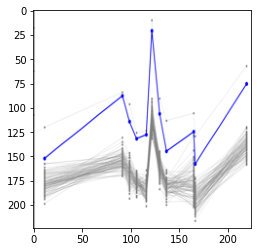

In [59]:
# Let's randomly check one CNV image
item = random.randint(0,len(combined_label))
print("Label:", combined_label[item])
func_dl.showImg(combined_img[item])
print(combined_img[item][100][0:10])

## Train the deep nerual model by hold-out validation

### Split dataset into training (80%) and testing (20%) dataset

In [61]:
## split image arrays
train_img, test_img, train_label, test_label, train_cnv_info_df, test_cnv_info_df = train_test_split(combined_img,
                                                                                                    combined_label_one_hot,
                                                                                                    combined_cnv_info_df,
                                                                                                    test_size=0.2,
                                                                                                    shuffle=True,
                                                                                                    random_state=seed)

train_img, val_img, train_label, val_label, train_cnv_info_df, val_cnv_info_df = train_test_split(train_img,
                                                                                                  train_label,
                                                                                                  train_cnv_info_df,
                                                                                                  test_size=0.25,
                                                                                                  shuffle=True,
                                                                                                  random_state=seed) # 0.25*0.8=0.2

combined_img.shape, train_img.shape, val_img.shape, test_img.shape
combined_label_one_hot.shape, train_label.shape, val_label.shape, test_label.shape

((22008, 3), (13204, 3), (4402, 3), (4402, 3))

## CNN (Transfer learning and fine-tuning)

### Using the pretrained MobileNet v1 architecture
- Firstly, we keep all the weights of base model frozen to train the FC layers.

In [72]:
model_name='MobileNet_v1_fine_tuning'
base_model = tf.keras.applications.MobileNet(
                                weights='imagenet', # Load weights pre-trained model.
                                input_shape=(224, 224, 3),  
                                include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3)) 
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nClasses,activation='softmax')(x)
model   = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,075
Non-trainable params: 3,228,864
_________________________________________________________________


In [75]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', func_dl.f1_m, func_dl.precision_m, func_dl.recall_m])

In [76]:
print("Training by MobileNet_v1 model ...")

model_file = output_model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

es = EarlyStopping(monitor  ='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode   ='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size = batch_size, 
                    epochs =epochs,
                    verbose=1, 
                    validation_data=(val_img, val_label), 
                    callbacks=[es, mc])

print("\n")
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

Training by MobileNet_v1 model ...
Epoch 1/20
413/413 [==============================] - ETA: 0s - loss: 0.3791 - accuracy: 0.8555 - f1_m: 0.8478 - precision_m: 0.8695 - recall_m: 0.8298
Epoch 00001: val_accuracy improved from -inf to 0.88778, saving model to /home/rt2776/cnv_espresso/project4_method_development/train/rare_entire_cnv_MobileNet_v1_fine_tuning_3classes.h5
413/413 [==============================] - 28s 67ms/step - loss: 0.3791 - accuracy: 0.8555 - f1_m: 0.8478 - precision_m: 0.8695 - recall_m: 0.8298 - val_loss: 0.2910 - val_accuracy: 0.8878 - val_f1_m: 0.8870 - val_precision_m: 0.8946 - val_recall_m: 0.8796
Epoch 2/20
413/413 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.8961 - f1_m: 0.8952 - precision_m: 0.9007 - recall_m: 0.8898
Epoch 00002: val_accuracy did not improve from 0.88778
413/413 [==============================] - 24s 58ms/step - loss: 0.2732 - accuracy: 0.8961 - f1_m: 0.8952 - precision_m: 0.9007 - recall_m: 0.8898 - val_loss: 0.30


--- Confusion matrix for test data ---

3 classes label: 0-True del; 1-True dip; 2-True dup


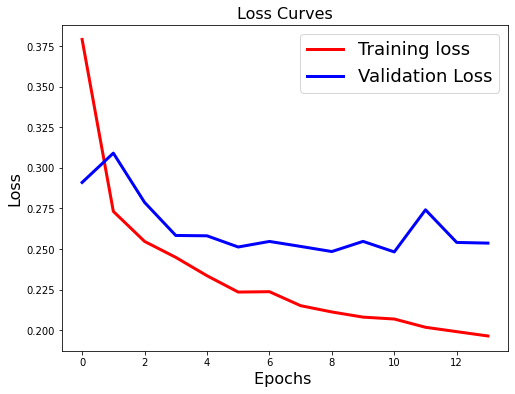

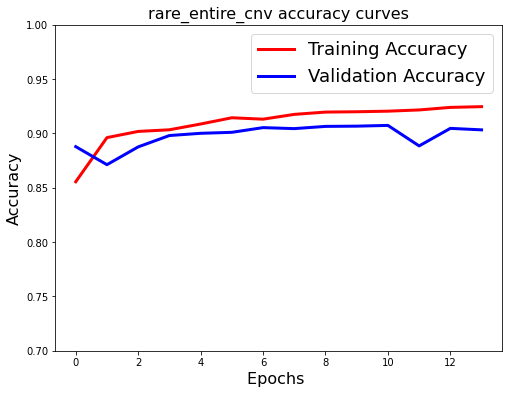

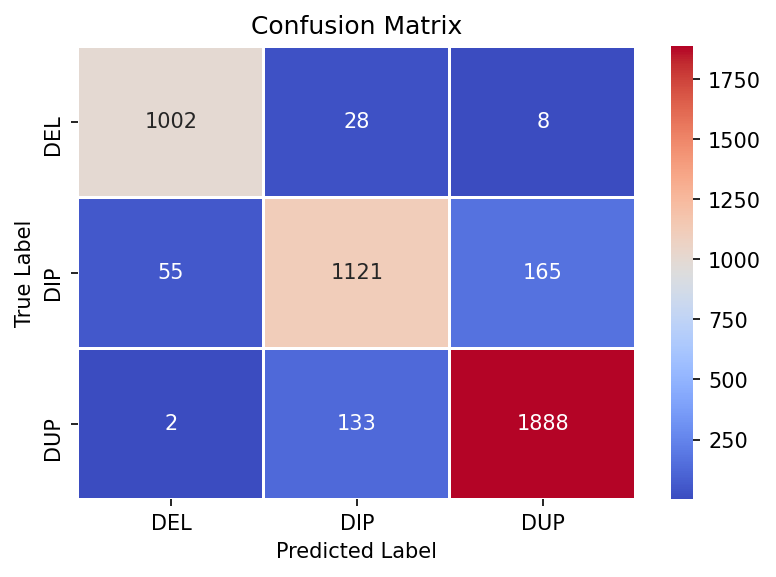


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1038
           1       0.87      0.84      0.85      1341
           2       0.92      0.93      0.92      2023

    accuracy                           0.91      4402
   macro avg       0.91      0.91      0.91      4402
weighted avg       0.91      0.91      0.91      4402



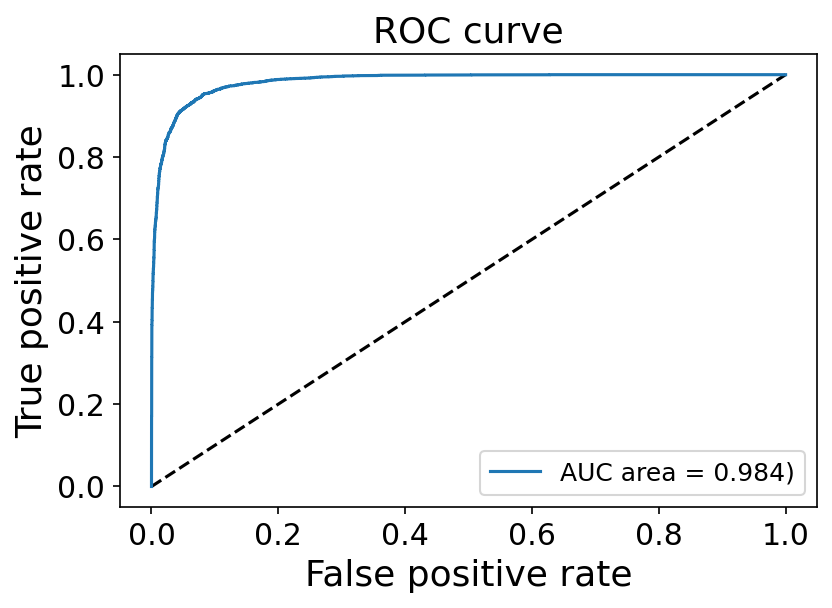

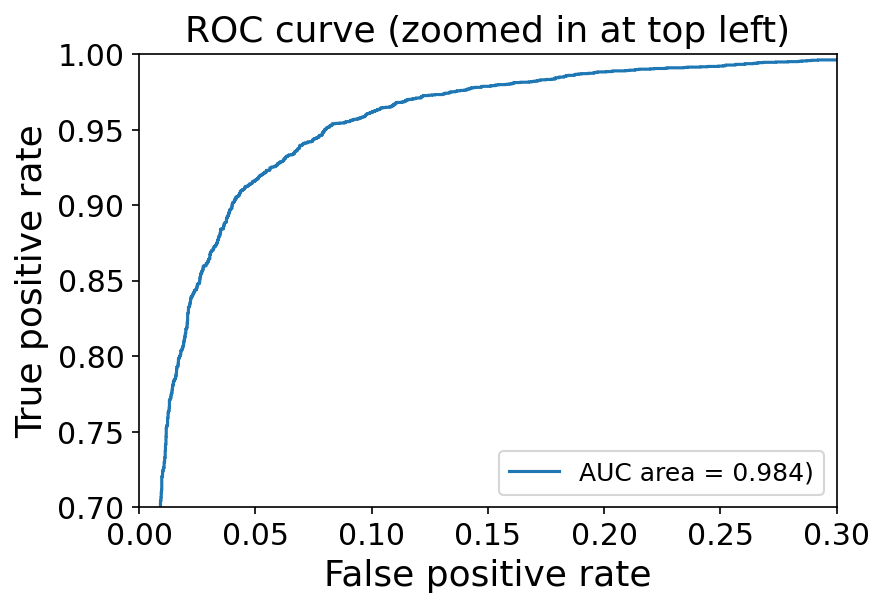

In [77]:
func_dl.draw_loss_accuracy_curves(history, project_name)
func_dl.confusion_matrix(model, test_img, test_label, nClasses)
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label)
func_dl.draw_single_roc_curve(tpr, fpr, auc)

### Fine-tuning
- Secondly, Once your model has converged on our train data, we unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate.

In [78]:
print("Fine tuning by MobileNet_v1 model ...")
model_file = output_model_dir + project_name + "_" + model_name + "_" + str(nClasses) + "classes.h5"

base_model.trainable=True
model.summary()

Fine tuning by MobileNet_v1 model ...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


In [79]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy', metrics=['accuracy', func_dl.f1_m, func_dl.precision_m, func_dl.recall_m])

In [80]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(model_file,
                     monitor='val_accuracy',
                     mode   ='max', 
                     verbose=1, 
                     save_best_only=True)

history = model.fit(train_img, train_label,
                    batch_size = batch_size, 
                    epochs  = epochs,
                    verbose = 1, 
                    validation_data = (val_img, val_label), 
                    callbacks = [es, mc])
print("\n")
loss, accuracy, f1_score, precision, recall = model.evaluate(test_img, test_label)

Epoch 1/20
413/413 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9106 - f1_m: 0.9107 - precision_m: 0.9127 - recall_m: 0.9087
Epoch 00001: val_accuracy improved from -inf to 0.89505, saving model to /home/rt2776/cnv_espresso/project4_method_development/train/rare_entire_cnv_MobileNet_v1_fine_tuning_3classes.h5
413/413 [==============================] - 84s 204ms/step - loss: 0.2265 - accuracy: 0.9106 - f1_m: 0.9107 - precision_m: 0.9127 - recall_m: 0.9087 - val_loss: 0.3030 - val_accuracy: 0.8950 - val_f1_m: 0.8946 - val_precision_m: 0.8958 - val_recall_m: 0.8934
Epoch 2/20
413/413 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9276 - f1_m: 0.9280 - precision_m: 0.9295 - recall_m: 0.9266
Epoch 00002: val_accuracy improved from 0.89505 to 0.90209, saving model to /home/rt2776/cnv_espresso/project4_method_development/train/rare_entire_cnv_MobileNet_v1_fine_tuning_3classes.h5
413/413 [==============================] - 84s 204ms/step - los


--- Confusion matrix for test data ---

3 classes label: 0-True del; 1-True dip; 2-True dup


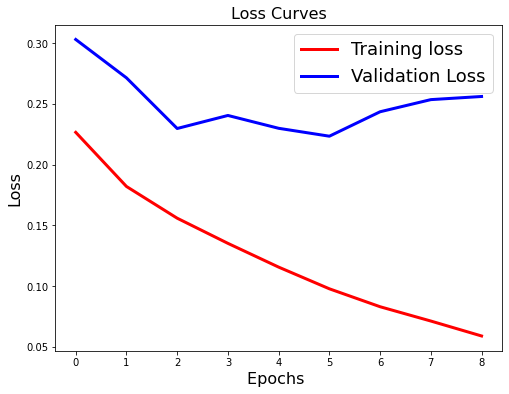

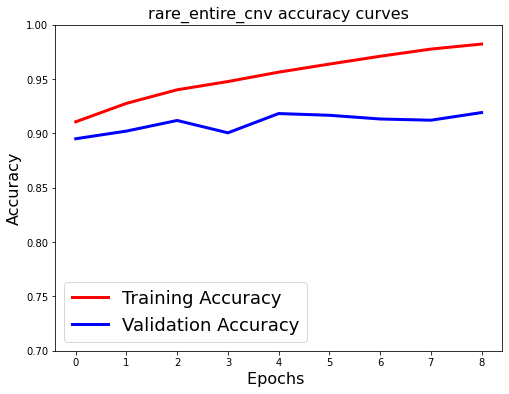

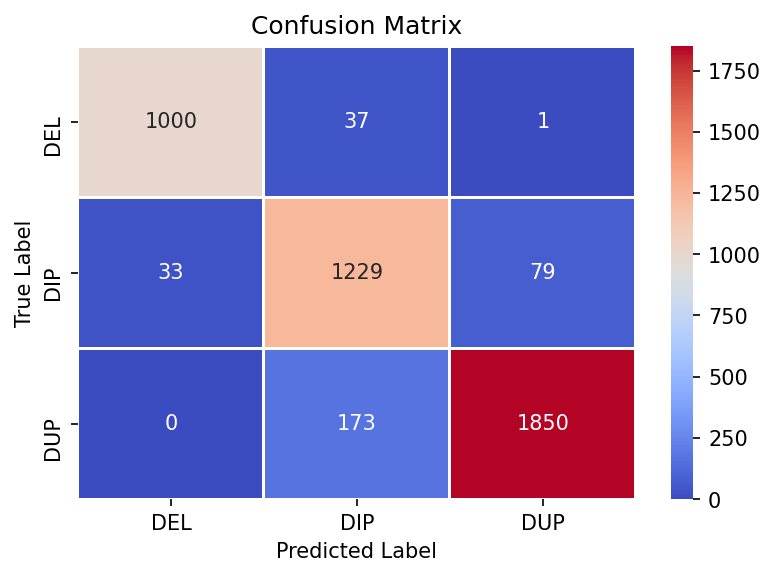


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1038
           1       0.85      0.92      0.88      1341
           2       0.96      0.91      0.94      2023

    accuracy                           0.93      4402
   macro avg       0.93      0.93      0.93      4402
weighted avg       0.93      0.93      0.93      4402



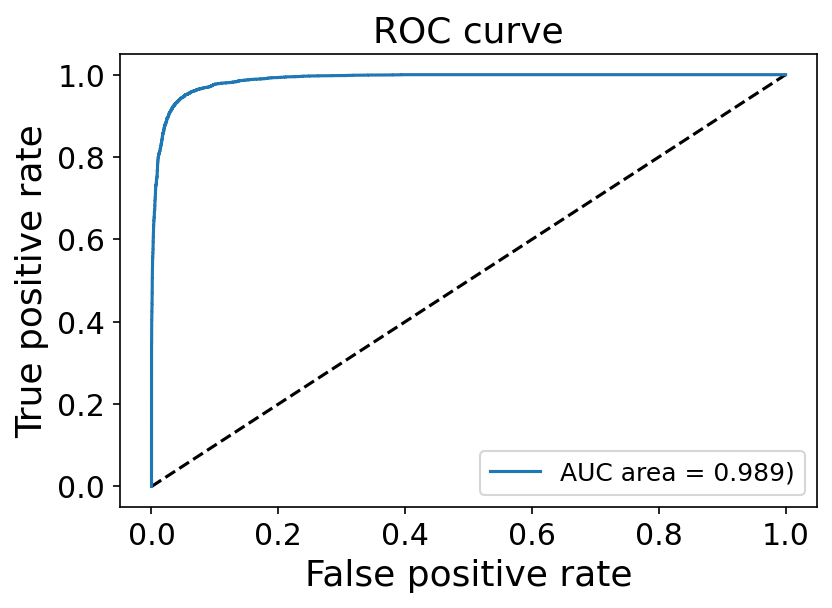

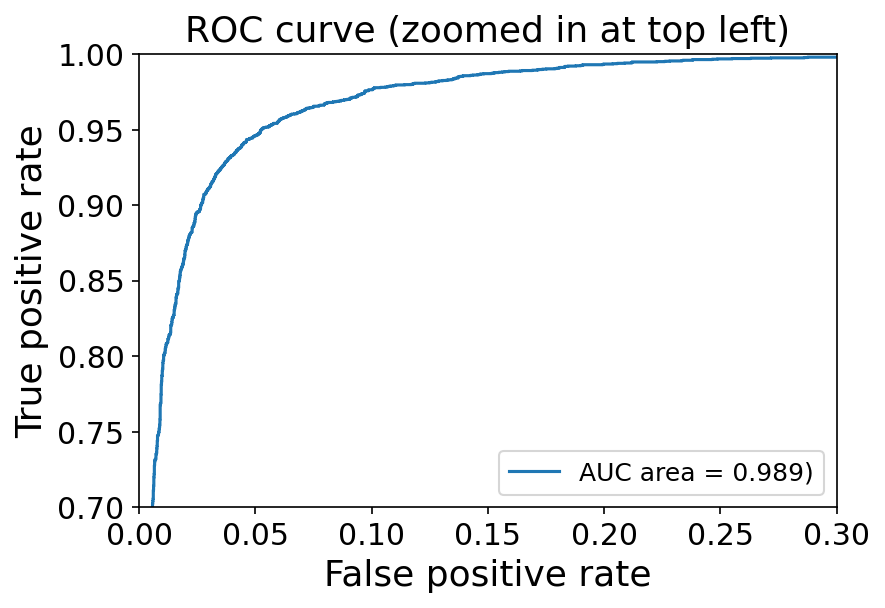

In [81]:
func_dl.draw_loss_accuracy_curves(history, project_name)
func_dl.confusion_matrix(model, test_img, test_label, nClasses)
fpr, tpr, thresholds, auc = func_dl.pred_roc_data(model, test_img, test_label)
func_dl.draw_single_roc_curve(tpr, fpr, auc)

In [84]:
func.showDateTime()
print("[Done]. Please check the trained model at",model_file)

[2021.05.10-16:08:01]
[Done]. Please check the trained model at /home/rt2776/cnv_espresso/project4_method_development/train/rare_entire_cnv_MobileNet_v1_fine_tuning_3classes.h5
